# Diving into YouTube Analytics

Deepnote presented a live stream featuring a showcase of how to use Google's YouTube API. We had a few Deepnote coders and a Deepnote user Allan who helped crack the API and start getting data. Below is a project inspired from that stream!

In this notebook we are going to dive in and check out the popular YouTube channel Good Mythical Morning.<img src="https://static.wikia.nocookie.net/logopedia/images/b/b9/R%26L%27s_GMM_2017_logo_%28WithITF%29.png/revision/latest/scale-to-width-down/340?cb=20170818134133" title="GMM" width="5%" height="5%" />

## Imports

In this section we are going to import our libraries.

In [1]:
from googleapiclient.discovery import build
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Setup
First you will need to create an API key by going to [API signup](https://console.developers.google.com/). Then I created an enviroment variable in Deepnote by selecting integrations on the side menu. Call it whatever you would like and paste in your key. Now we can grab our API key out of our Deepnote integration and setup our youtube variable. 

In [2]:
API_KEY = os.environ["API"]
CHANNEL_ID = "UC4PooiX37Pld1T8J5SYT-SQ"
youtube = build('youtube', 'v3', developerKey=API_KEY)

## API Functions

In this section we setup some API functions to help us gather data. We create a function to gather channel stats and video stats. To do this in a effecient way and save API calls we do not use the search function. We pull in GMM's upload playlist ( containing all of their videos ) and use that to build a video list. Then grab the data from each video. 

In [3]:
# Function to get the channels stats
# It will also contain the upload playlist ID we can use to grab videos.
def get_channel_stats(youtube, channel_id):
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=channel_id
    )
    response = request.execute()
    
    return response['items']

In [21]:
# This will get us a list of videos from a playlist.
# Note a page of results has a max value of 50 so we will
# need to loop over our results with a pageToken

def get_video_list(youtube, upload_id):
    video_list = []
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=upload_id,
        maxResults=50
    )
    next_page = True
    while next_page:
        response = request.execute()
        data = response['items']

        for video in data:
            video_id = video['contentDetails']['videoId']
            if video_id not in video_list:
                video_list.append(video_id)

        # Do we have more pages?
        if 'nextPageToken' in response.keys():
            next_page = True
            request = youtube.playlistItems().list(
                part="snippet,contentDetails",
                playlistId=upload_id,
                pageToken=response['nextPageToken'],
                maxResults=50
            )
        else:
            next_page = False

    return video_list

In [22]:
# Once we have our video list we can pass it to this function to get details.
# Again we have a max of 50 at a time so we will use a for loop to break up our list. 

def get_video_details(youtube, video_list):
    stats_list=[]

    # Can only get 50 videos at a time.
    for i in range(0, len(video_list), 50):
        request= youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=video_list[i:i+50]
        )

        data = request.execute()
        for video in data['items']:
            title=video['snippet']['title']
            published=video['snippet']['publishedAt']
            description=video['snippet']['description']
            tag_count= len(video['snippet']['tags'])
            view_count=video['statistics'].get('viewCount',0)
            like_count=video['statistics'].get('likeCount',0)
            dislike_count=video['statistics'].get('dislikeCount',0)
            comment_count=video['statistics'].get('commentCount',0)
            stats_dict=dict(title=title, description=description, published=published, tag_count=tag_count, view_count=view_count, like_count=like_count, dislike_count=dislike_count, comment_count=comment_count)
            stats_list.append(stats_dict)

    return stats_list

### Create our channel stats

In [6]:
channel_stats = get_channel_stats(youtube, CHANNEL_ID)

### Find our upload playlist ( will contain all video uploads )

In [7]:
upload_id = channel_stats[0]['contentDetails']['relatedPlaylists']['uploads']
upload_id

'UU4PooiX37Pld1T8J5SYT-SQ'

### Get our Video List

In [8]:
video_list = get_video_list(youtube, upload_id)

### Get our Video Details

Finally we will get all of our videos details returned in a dictionary.

In [9]:
video_data = get_video_details(youtube, video_list)

## Creating Visualizations
In this section we will covert our data to pandas dataframe and start visualizing. I have also created a CSV of data in the cell below if you don't want to do the API calls yourself.

In [20]:
df=pd.DataFrame(video_data)
df['title_length'] = df['title'].str.len()
df["view_count"] = pd.to_numeric(df["view_count"])
df["like_count"] = pd.to_numeric(df["like_count"])
df["dislike_count"] = pd.to_numeric(df["dislike_count"])
df["comment_count"] = pd.to_numeric(df["comment_count"])
# reaction used later add up likes + dislikes + comments
df["reactions"] = df["like_count"] + df["dislike_count"] + df["comment_count"] + df["comment_count"]
df.to_csv("GMM-Data.csv")
df.head()

,title,description,published,tag_count,view_count,like_count,dislike_count,comment_count,title_length,reactions
0,Carbonated Food Taste Test,"Today, we're eatin some carbonated food. GMM #...",2021-03-12T11:00:18Z,12,846178,28855,443,1154,26,31606
1,Who Can Make The Loudest Noise? (Challenge),"In today's game, we're seeing who can make the...",2021-03-11T11:00:13Z,12,699012,26996,350,1388,43,30122
2,Is Anything Better Than Ranch On Wings? (Taste...,Thanks to BetterHelp for sponsoring today’s ep...,2021-03-10T11:00:30Z,12,1149425,38935,779,2343,52,44400
3,Putting Weird Things In A Pitching Machine,"Today, we're seeing what happens when we put t...",2021-03-09T11:00:03Z,12,726717,32868,1073,1842,42,37625
4,Will It Deep Dish Pizza? Taste Test,"Today, we ask the age old question... Will It ...",2021-03-08T11:00:18Z,12,1651567,54782,593,2366,35,60107


### Plotting Number of Tags Per Video

/shared-libs/python3.7/py/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[Text(0.5, 0, 'Number of Tags Used'), Text(0, 0.5, 'Occurrences')]

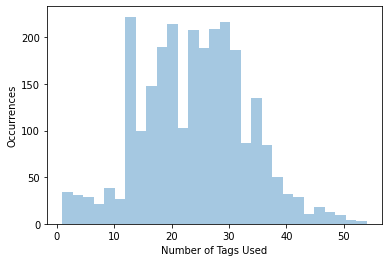

In [11]:
# Histogram of tag count.
chart = sns.distplot( a=df["tag_count"], hist=True, kde=False, rug=False )
chart.set(xlabel='Number of Tags Used', ylabel='Occurrences')

### Title Length Used

[Text(0.5, 0, 'Title Length'), Text(0, 0.5, 'Occurrences')]

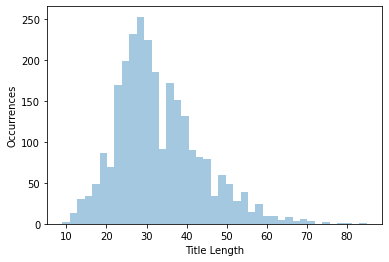

In [12]:
chart = sns.distplot( a=df["title_length"], hist=True, kde=False, rug=False )
chart.set(xlabel='Title Length', ylabel='Occurrences')

### Most Viewed Videos

In [13]:
df_highest_views = df.nlargest(10, 'view_count')
df_highest_views['title'] = df_highest_views['title'].str[:40]
df_highest_views['view_count_millions'] = df_highest_views['view_count'] / 1000000
df_highest_views

,title,description,published,tag_count,view_count,like_count,dislike_count,comment_count,title_length,reactions,view_count_millions
1475,Amazing Game Show Cheaters,Whammy! Some people are straight up cheaters. ...,2016-04-05T10:00:00Z,29,30887288,285414,28684,14412,26,342922,30.887288
1863,World’s Hottest Pepper Challenge: Caroli,We eat the World's Hottest Chili Pepper -- the...,2014-09-30T10:00:02Z,36,29407723,431821,10678,40635,49,523769,29.407723
2013,Eating a Scorpion: Bug War Challenge,"We're going to eat grasshoppers, pupae, and a ...",2014-03-28T10:00:01Z,24,27931612,288652,12033,27880,36,356445,27.931612
1827,Making Real Food w/ Play-Doh Toys,"Everyone thinks about eating Play-Doh, but we ...",2014-11-11T11:00:10Z,47,25413943,205526,8124,25499,33,264648,25.413943
1869,Will It Deep Fry? - Taste Test,Eggs? Lemon? Sunglasses? Today we ask the age ...,2014-09-23T10:00:02Z,47,24515648,217421,5495,23318,30,269552,24.515648
1917,Will It Ice Cream Sandwich? Taste Test,We eat some interesting ice cream sandwiches. ...,2014-07-29T10:00:01Z,42,23652799,245787,4558,30708,38,311761,23.652799
2200,The Most Amazing Optical Illusions on th,Your mind will explode when we show you all th...,2013-03-18T14:37:16Z,20,22403009,106198,15266,11265,50,143994,22.403009
1815,Will It Popsicle? Taste Test,Will our favorite foods be just as delicious i...,2014-11-25T11:00:11Z,47,21501812,223768,4481,24315,28,276879,21.501812
1948,8 Weird Ways To Open A Bottle,Today we're poppin' bottles 8 different ways. ...,2014-06-17T10:00:01Z,34,21246029,237133,7713,23003,29,290852,21.246029
1987,Will It Taco? - Taste Test,We test out some interesting taco ingredients....,2014-05-05T10:00:01Z,37,20469963,217477,4971,30006,26,282460,20.469963


(20.0, 32.0)

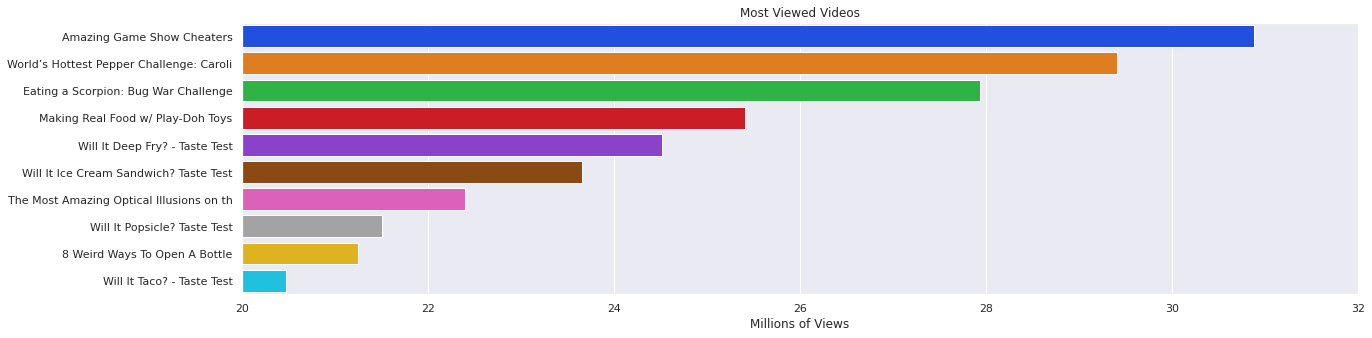

In [14]:
sns.set(rc={'figure.figsize':(20,5)})
plot = sns.barplot(x="view_count_millions", y="title", data=df_highest_views, palette="bright")
plot.set(xlabel='Millions of Views', ylabel='')
plot.set_title('Most Viewed Videos')
plt.xlim(20, 32)

### Most Reacted to Videos (Likes + Thumbs down + Comments)

In [15]:
# Most Interations ( Like + Dislikes + Comments)
df_highest_reactions = df.nlargest(10, 'reactions')
df_highest_reactions['title'] = df_highest_reactions['title'].str[:40]
df_highest_reactions['reactions'] = df_highest_reactions['reactions'] / 1000
df_highest_reactions

,title,description,published,tag_count,view_count,like_count,dislike_count,comment_count,title_length,reactions
303,International Taco Bell Taste Test,"Today, we're trying Taco Bell items from AROUN...",2019-11-11T11:00:10Z,20,6495254,641317,4758,5223,34,656.521
1856,Swedish Stereotypes ft. PewDiePie,"Real life Swede, PewDiePie, schallenges us to ...",2014-10-08T10:00:26Z,47,16802368,429515,8756,57324,33,552.919
1863,World’s Hottest Pepper Challenge: Caroli,We eat the World's Hottest Chili Pepper -- the...,2014-09-30T10:00:02Z,36,29407723,431821,10678,40635,49,523.769
301,Alternate Universe Snacks Taste Test,"Today, we're reaching back into the Multiverse...",2019-11-13T11:00:02Z,11,3709836,346425,3558,3478,36,356.939
2013,Eating a Scorpion: Bug War Challenge,"We're going to eat grasshoppers, pupae, and a ...",2014-03-28T10:00:01Z,24,27931612,288652,12033,27880,36,356.445
299,Can This Pill Take The Sugar Out Of Swee,Does this Sweet Defeat pill really work? We tr...,2019-11-15T11:00:02Z,21,3410306,346588,3147,3202,47,356.139
1140,Can This Pill Take The Spice Out of Spic,We found a pill that makes spicy food NOT spic...,2017-07-03T10:00:00Z,29,14682631,310344,6844,18373,47,353.934
1475,Amazing Game Show Cheaters,Whammy! Some people are straight up cheaters. ...,2016-04-05T10:00:00Z,29,30887288,285414,28684,14412,26,342.922
1763,Will It Pizza? Taste Test,Today we open pandoras box of pizza. GMM #624!...,2015-02-18T11:00:01Z,38,19237424,246387,4227,34609,25,319.832
1981,Locked in a Sensory Deprivation Tank,We spend 60 minutes inside a sensory deprivati...,2014-05-13T10:00:01Z,32,16738106,273475,5188,20088,36,318.839


(300.0, 700.0)

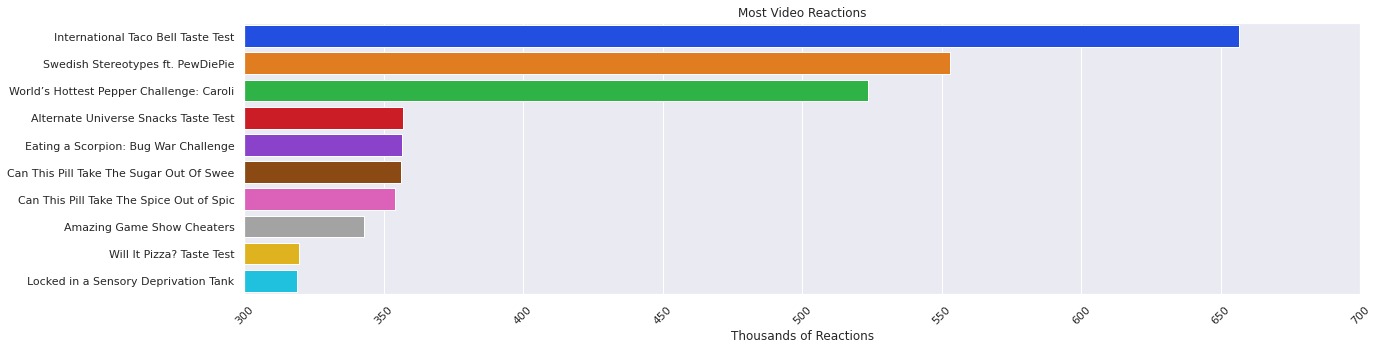

In [16]:
sns.set(rc={'figure.figsize':(20,5)})
plot = sns.barplot(y="title", x="reactions", data=df_highest_reactions, palette="bright")
plot.set(xlabel='Thousands of Reactions', ylabel='')
plt.xticks(rotation=45)
plot.set_title('Most Video Reactions')
plt.xlim(300, 700)

### Most Thumbs downed Videos

In [17]:
df_highest_disliked = df.nlargest(10, 'dislike_count')
df_highest_disliked['title'] = df_highest_disliked['title'].str[:40]
df_highest_disliked['dislike_count'] = df_highest_disliked['dislike_count'] / 1000
df_highest_disliked

,title,description,published,tag_count,view_count,like_count,dislike_count,comment_count,title_length,reactions
1093,Why I Left GMM,"Hey Mythical Beasts, we just wanted to make th...",2017-10-09T10:00:05Z,36,6391042,163103,51.247,29754,14,273858
523,Fortnite Dance Challenge ft. Ninja,"We've asked Ninja, the King of Fortnite, to ra...",2018-12-19T11:00:00Z,20,5698978,76998,34.954,15471,34,142894
1477,11 Minutes of Silence,Let's not talk about that. GMM #891! \nGood My...,2016-04-01T10:00:02Z,31,4178539,155069,29.081,42470,21,269090
1475,Amazing Game Show Cheaters,Whammy! Some people are straight up cheaters. ...,2016-04-05T10:00:00Z,29,30887288,285414,28.684,14412,26,342922
456,Wish.com vs. Retail Cost (GAME),Thanks to Wish for sponsoring today’s episode!...,2019-03-14T10:00:01Z,33,3591066,51347,27.771,5228,31,89574
1727,7 Bromas para el Día de los Inocentes,Nunca es demasiado tarde para hacer algunas br...,2015-04-01T10:00:00Z,35,10154395,113155,27.248,17997,37,176397
2140,6 Legal Things That Should Be Illegal,We've decided that if you do any of these thin...,2013-10-09T10:00:02Z,32,8001977,68565,15.346,28520,37,140951
2200,The Most Amazing Optical Illusions on th,Your mind will explode when we show you all th...,2013-03-18T14:37:16Z,20,22403009,106198,15.266,11265,50,143994
781,Burnt Food Taste Test ft. Padma Lakshmi,Can Top Chef's Padma Lakshmi correctly guess b...,2018-03-08T11:00:03Z,16,1949775,27244,15.054,6905,46,56108
203,Dad Meme Review (Quarantine Episode),"Today, we're testing our meme skills and seein...",2020-04-08T10:00:37Z,17,1220111,40095,14.769,4536,36,63936


(10.0, 55.0)

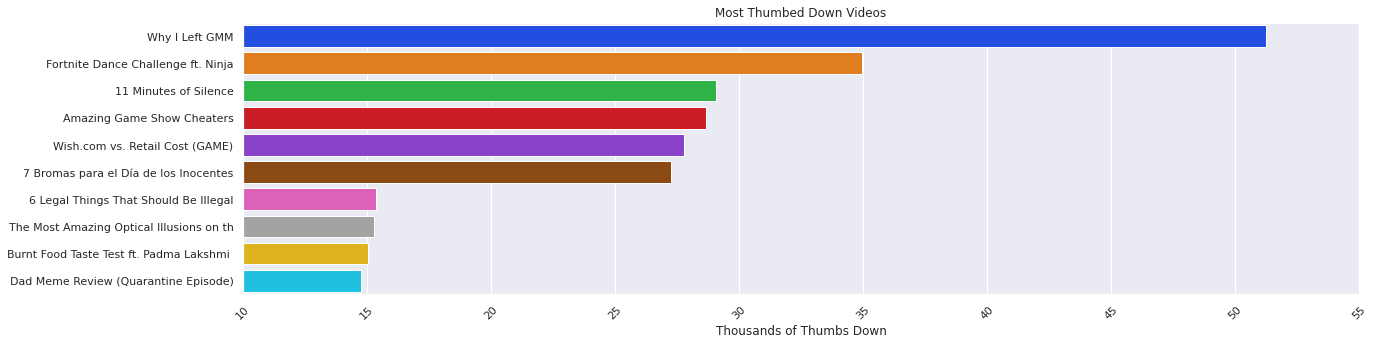

In [19]:
sns.set(rc={'figure.figsize':(20,5)})
plot = sns.barplot(y="title", x="dislike_count", data=df_highest_disliked, palette="bright")
plot.set(xlabel='Thousands of Thumbs Down', ylabel='')
plt.xticks(rotation=45)
plot.set_title('Most Thumbed Down Videos')
plt.xlim(10, 55)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=401eace2-3667-422d-960c-9fabaad04025' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>